# Machine Learning LAB 2B: LINEAR REGRESSION

Course 2025/26: *F. Chiariotti*

The notebook contains some simple tasks to be performed with **LINEAR REGRESSION MODELS**.

Complete all the **required code sections**.

### IMPORTANT for the exam:

The functions you might be required to implement in the exam will have the same signature and parameters as the ones in the labs

## VR traffic prediction

In this notebook, we will explore the prediction of Virtual Reality (VR) traffic. The data come from the paper:

Lecci, Mattia, _et al._ "An open framework for analyzing and modeling XR network traffic." IEEE Access 9 (2021): 129782-129795.

The VR game Virus Popper was instantiated on a computer through the RiftCat application: the user could then see the virtual content on their phone, which was strapped to their head with a Cardboard viewer. The file virus_popper.csv contains three columns from the traffic capture:
idx    | frame size (B) |  time (s)
0      | 38424          |  0.0
1      | 39801          |  0.01944
...

The game was run at 60 frames per second, with a target rate of 30 Mb/s. The task is then to predict the size of the next frame, given the past N frames. This was explored in another paper:

Chiariotti, Federico, _et al._ "Temporal characterization and prediction of vr traffic: A network slicing use case." IEEE Transactions on Mobile Computing 23.5 (2023): 3890-3908.

---

## Import all the necessary Python libraries

In [1]:
import numpy as np
import pandas as pd
import random as rnd
from matplotlib import pyplot as plt
from sklearn import linear_model, preprocessing
from sklearn.model_selection import train_test_split

np.random.seed(1)

def load_dataset(filename):
    data_train = pd.read_csv(filename)
    data = data_train.iloc[:, 1].values # Get the second column (frame size) as the input
    return data

# Load the dataset
data = load_dataset('data/virus_popper.csv')

## Prepare the data and create training and test sets

In this case, we are learning a time series: let us consider a memory of 2 samples, i.e., use X[n-1] and X[n-2] to predict X[n].

In [2]:
# Normalize the dataset
avg_size = np.mean(data)
norm_data = np.asarray(data) / avg_size #---> normalized to mean 1

# Compute the splits and prepare the columns
m_training = int(0.75*norm_data.shape[0]) #---> 75 % of data for training

X_training = np.ones([m_training - 2, 3])
X_training[:,1] = norm_data[: m_training - 2]
X_training[:,2] = norm_data[1 : m_training - 1]
Y_training = norm_data[2 : m_training]


X_test = np.ones([norm_data.shape[0] - m_training - 2, 3])
X_test[:,1] = norm_data[m_training : -2]
X_test[:,2] = norm_data[m_training + 1 : -1]
Y_test = norm_data[m_training + 2:]

print(np.shape(X_training), np.shape(Y_training), np.shape(X_test), np.shape(Y_test))

(25878, 3) (25878,) (8625, 3) (8625,)


## Least Squares linear regression

Train and evaluate the LS regressor on the data

In [3]:
xm=np.array([[1,2],[3,4],[5,6]])
print(xm)
w=np.array([0.2, -0.1])
#wt=np.transpose(w)
print(w)

r=np.dot(xm,w)
print(r)
ms=np.sum(r)
print(ms)
print(r.size)

[[1 2]
 [3 4]
 [5 6]]
[ 0.2 -0.1]
[0.  0.2 0.4]
0.6
3


In [4]:
# Least squares solution
def least_squares(X_matrix: np.ndarray, labels: np.ndarray): #-> None:
    ## Run the LS algorithm without regularization
    X_matrix_transpose = np.transpose(X_matrix)
    A_matrix = np.matmul(X_matrix_transpose, X_matrix)
    b_matrix = np.dot(X_matrix_transpose, labels)
    weights = np.linalg.solve(A_matrix, b_matrix)
    return weights

def evaluate_model(x, y, coeff): # ---> matrixes 
    ## Return the average MSE for the set over which we evaluate
    n_samples = np.shape(x)[0]
    #print(n_samples)
    predicted_y = np.dot(x,coeff)
    average_mse = np.sum((predicted_y - y)**2) / n_samples
    return average_mse

In [5]:
# Run the LS training and test it on the test data
trained_model = least_squares(X_training, Y_training)
mse = evaluate_model(X_test, Y_test, trained_model)
print('Model coefficients:', trained_model)
print('Root MSE:', np.sqrt(mse) * avg_size) # ---> actual mse is 0.12

Model coefficients: [0.36986742 0.20348677 0.42565451]
Root MSE: 7712.3547215392055


---

## Least Squares with Tikhonov regularization

Perform K-fold cross validation with $\lambda\in\{0, 0.1, 1, 10\}$

In [6]:
# Least squares solution
def regularized_least_squares(X_matrix: np.ndarray, labels: np.ndarray, lambda_vec: np.ndarray): #-> None:
    ## Run the LS algorithm with regularization
    n_samples = np.shape(X_matrix)[0]
    X_matrix_transpose = np.transpose(X_matrix)
    A_matrix = np.matmul(X_matrix_transpose, X_matrix)
    n_features = np.shape(X_matrix)[1]
    new_A_matrix = lambda_vec * np.identity(n_features) + A_matrix # ---> NB no "2m" factor (simply a convention used here)
    b_matrix = np.dot(X_matrix_transpose, labels)
    weights = np.linalg.solve(new_A_matrix, b_matrix)
    return weights
    
def K_fold(X_training: np.ndarray, Y_training: np.ndarray, lambda_vec: np.ndarray, K: np.ndarray): #-> None:
    n_samples = np.shape(X_training)[0]
    n_labels = np.shape(Y_training)[0]
    perm = np.arange(n_samples)
    rnd.shuffle(perm)
    X_shuffled = np.asarray(X_training[perm, :])
    Y_shuffled = np.asarray(Y_training[perm])
    model_best = -1 # ---> later, the array of the weights (ie the solution, the model)
    mse_given_lambda_best = 1e20
    results = []
    models = []
    # Divide training set in K folds
    n_points_per_fold = int(np.floor(n_labels / K))
    for lambda_idx in range(len(lambda_vec)): # ---> for each lambda value in the list
        mse_given_lambda = 0
        for i in range(K): # ---> for every fold 
            x_train_fold = np.concatenate([X_shuffled[: n_points_per_fold * i, :], X_shuffled[n_points_per_fold * (i + 1) + 1 :, :]])
            # ---> eg for i=2 (second fold) and 50 points per fold, we get X_shuffled[:50*2,:] concatenated to X_shuffled[50*3+1:,:]
            #      ie all X_shuffled except for 100th to the 150th samples (included)
            y_train_fold = np.concatenate([Y_shuffled[: n_points_per_fold * i], Y_shuffled[n_points_per_fold * (i + 1) + 1 :]])
            x_validate_fold = X_shuffled[n_points_per_fold * i : n_points_per_fold * (i + 1) + 1, :]
            # ---> eg 100th to the 150th (included) points
            y_validate_fold = Y_shuffled[n_points_per_fold * i : n_points_per_fold * (i + 1) + 1]
            k_model = regularized_least_squares(x_train_fold, y_train_fold, lambda_vec[lambda_idx]) # ---> train on training folds
            mse_given_lambda += evaluate_model(x_validate_fold, y_validate_fold, k_model) # ---> evaluate MSE (ie validate model) on validation fold
            # ---> increment MSE (for a fixed lambda_idx) for a given fold to get total MSE on all folds,
            #      ie MSE on all dataset (for a fixed lambda_idx)
        mse_given_lambda /= K
        # ---> normalize (irrelevant here, as K is fixed hyperparameter;
        #      if however different Ks for same lambda, would have to weigh by fraction of points in the fold
        #      - so dividing by K seems meaningless in any case)
        results.append(mse_given_lambda)
        models.append(regularized_least_squares(X_shuffled, Y_shuffled, lambda_vec[lambda_idx]))
        # ---> retrain model on all dataset
        if (mse_given_lambda<mse_given_lambda_best):
            # ---> compare the MSE just calculated (for a given lambda value) to the existing one
            model_best = regularized_least_squares(X_shuffled, Y_shuffled, lambda_vec[lambda_idx])
            mse_given_lambda_best = mse_given_lambda
    return model_best, mse_given_lambda_best, models, results 

In [25]:
# Run the training with K-fold cross-validation and plot the score
K = 5
lambda_par_list = [0, 0.1, 1, 10, 100]

best_model, mse_given_lambda_best, models, results = K_fold(X_training, Y_training, lambda_par_list, K)

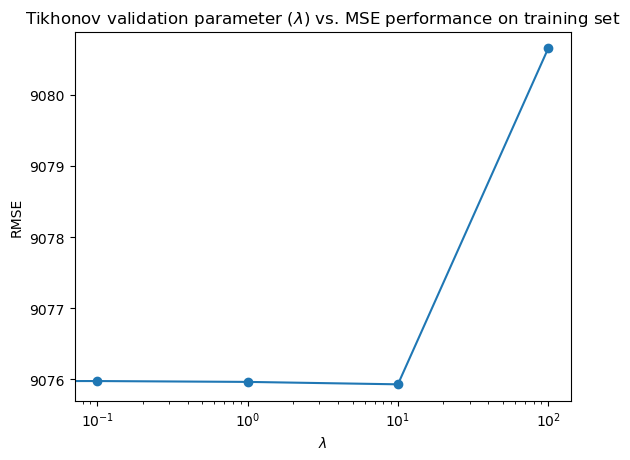

In [31]:
#print(best_model, results)
plt.semilogx(lambda_par_list, np.sqrt(results) * avg_size, 'o-') # ---> results is MSE / K, avg_size is mean
plt.title("Tikhonov validation parameter ($\lambda$) vs. MSE performance on training set")
plt.xlabel('$\lambda$')
plt.ylabel('RMSE')
plt.show()

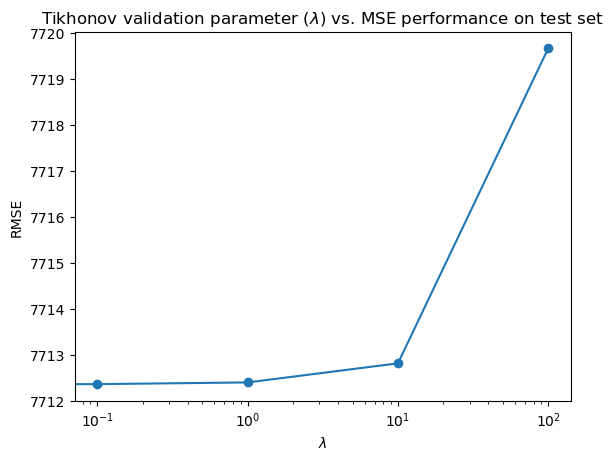

In [32]:
# Plot the results for the regularized models on the TEST set
# ---> regularization hurts generalization in this case. The data likely isn't overfitting enough to benefit from regularization.
test_scores = np.zeros(len(models))

for i in range(len(models)):
    test_scores[i] = evaluate_model(X_test, Y_test, models[i])
    
plt.semilogx(lambda_par_list, np.sqrt(test_scores) * avg_size, 'o-')
plt.title("Tikhonov validation parameter ($\lambda$) vs. MSE performance on test set")
plt.xlabel('$\lambda$')
plt.ylabel('RMSE')
plt.show()